In [1]:
import gc
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import scipy.cluster.hierarchy as shc

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [3]:
def get_clusters_info_elbow(data, center):
    kmeans = KMeans(n_clusters=center, max_iter=1000, random_state=42)
    kmeans.fit(data)
    score = kmeans.inertia_
    return score


def get_clusters_info_db(data, center):
    kmeans = KMeans(n_clusters=center, max_iter=1000, random_state=42)
    model = kmeans.fit_predict(data)
    score = davies_bouldin_score(data, model)
    return score

### Load data

In [4]:
data = pd.read_parquet('data/jeddah.pq')

In [5]:
(data.peak_customer != data.peak_captain).sum()

4716

In [6]:
data[data.peak_customer != data.peak_captain].head()

,booking_id,assignment_time,distance,duration,peak_captain,peak_customer,price
17,1696242175,2023-02-01 13:47:03.000,8.41072,19,1.0,1.2,28.71
85,1696237580,2023-02-01 13:42:20.000,7.00799,12,1.0,1.2,23.62
130,1696240385,2023-02-01 13:45:09.000,3.72984,6,1.0,1.2,15.75
223,1696233095,2023-02-01 13:36:57.000,6.40341,10,1.0,1.2,21.82
331,1696161169,2023-02-01 12:24:46.000,8.93770,9,1.0,1.2,25.73


In [7]:
data = data.drop('peak_captain', axis=1)\
    .rename(columns={'peak_customer': 'peak'})

data = data[(data.distance <= 40.0) & (data.duration <= 60.0)]

In [8]:
data_np = data[data.peak == 1.0].copy()
data_peak = data[data.peak > 1.0].copy()

In [9]:
len(data_np)

376361

In [10]:
len(data_peak)

115717

In [11]:
data_np.head()

,booking_id,assignment_time,distance,duration,peak,price
1,1696392998,2023-02-01 16:44:11.000,3.56332,8,1.0,12.90
4,1695987425,2023-02-01 08:39:02.000,22.45620,21,1.0,44.48
6,1696340483,2023-02-01 15:29:42.000,17.68660,21,1.0,35.68
8,1695985769,2023-02-01 08:36:16.000,1.04456,3,1.0,7.65
10,1695892659,2023-02-01 05:41:26.000,15.27040,16,1.0,22.91


In [12]:
features = data_np[['distance', 'duration']].copy()
scaler = StandardScaler()
features = scaler.fit_transform(features)
features = pd.DataFrame(features, columns=['distance', 'duration'])

### Selecting optimal K (No Peak)

100%|███████████████████████████████████████████| 28/28 [01:09<00:00,  2.49s/it]


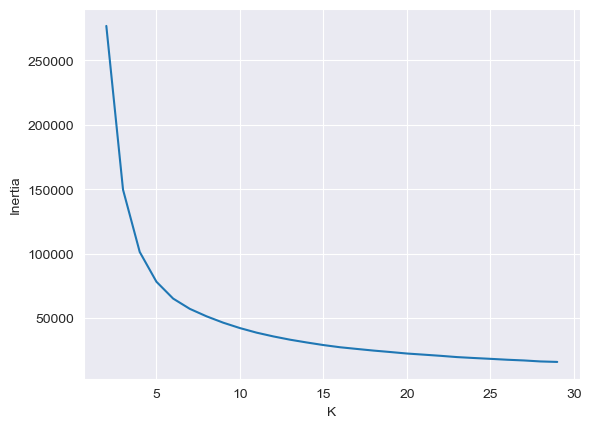

In [13]:
sse={}

for k in tqdm(range(2, 30)):
    sse[k] = get_clusters_info_elbow(features, k)
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("K")
plt.ylabel('Inertia')
plt.show()

100%|███████████████████████████████████████████| 28/28 [01:10<00:00,  2.53s/it]


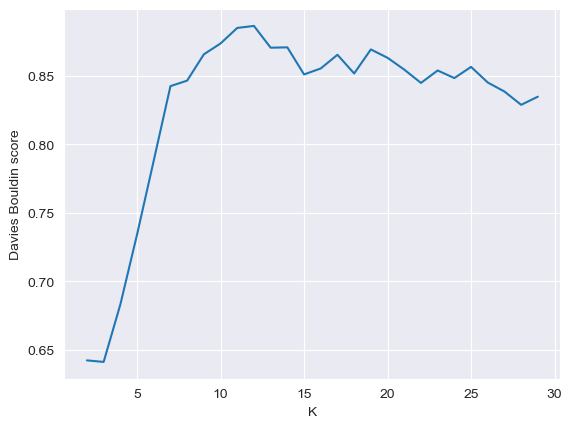

In [14]:
sse={}

for k in tqdm(range(2, 30)):
    sse[k] = get_clusters_info_db(features, k)
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('K')
plt.ylabel('Davies Bouldin score')
plt.show()

### Clustering (No Peak)

In [15]:
kmeans = KMeans(n_clusters=7, max_iter=1000, random_state=42)
kmeans.fit(features)

data_np['cluster'] = kmeans.predict(features)

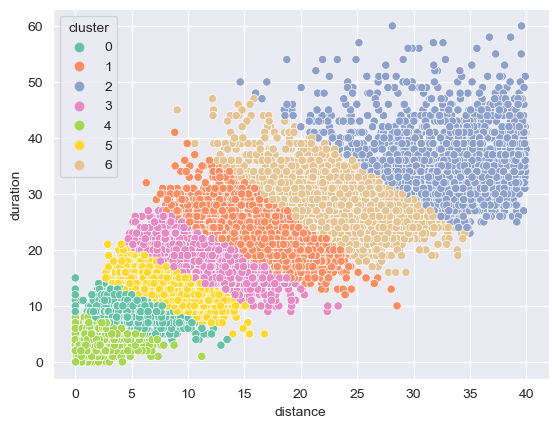

In [16]:
sns.scatterplot(data_np.sample(frac=0.2), x='distance', y='duration', hue='cluster', palette='Set2')
plt.savefig('pics/jeddah_no_peak.png')
plt.show()

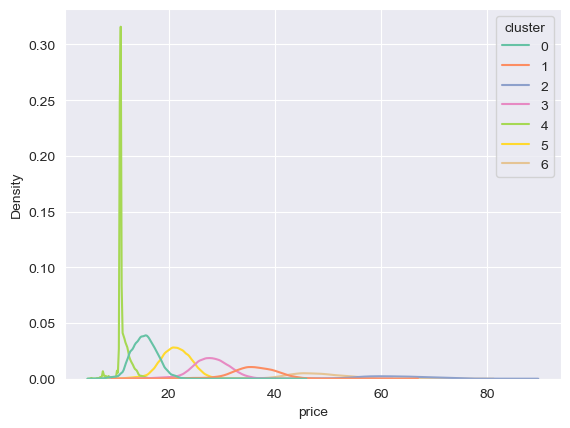

In [17]:
sns.kdeplot(data_np, x='price', hue='cluster', palette='Set2')
plt.savefig('pics/jeddah_no_peak_prices.png')
plt.show()

In [18]:
data_np.cluster.value_counts()

0    87649
5    77001
4    73100
3    60020
1    40579
6    24092
2    13920
Name: cluster, dtype: int64

<AxesSubplot: xlabel='price', ylabel='Density'>

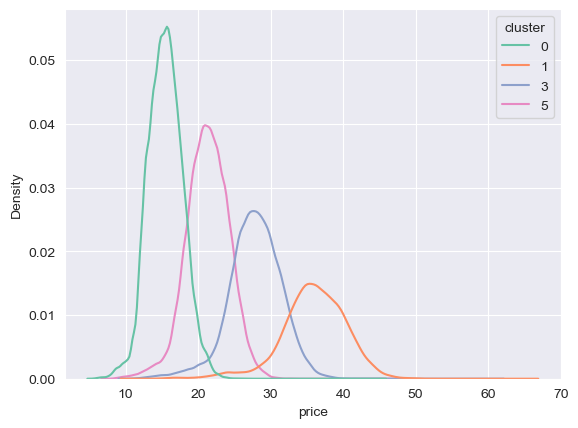

In [19]:
sns.kdeplot(data_np[~data_np.cluster.isin([4, 6, 2])], x='price', hue='cluster', palette='Set2')

In [20]:
def q_low(x):
    iqr = x.quantile(0.75) - x.quantile(0.25)
    return x.quantile(0.25) - (1.5*iqr)

def q_high(x):
    iqr = x.quantile(0.75) - x.quantile(0.25)
    return x.quantile(0.75) + (1.5*iqr)

ranges = data_np[['cluster', 'price']]\
    .groupby(by='cluster')\
    .agg(['mean', q_low, q_high])\
    .droplevel(axis=1, level=0)\
    .reset_index(drop=False)

In [21]:
ranges

,cluster,mean,q_low,q_high
0,0,15.488120,8.995000,21.914999
1,1,35.938574,25.175000,47.215000
2,2,62.067017,44.311249,80.041250
3,3,27.830909,18.880000,37.040000
4,4,11.370727,9.745000,12.905000
5,5,21.317896,13.580001,29.179999
6,6,47.217706,33.240005,61.479996


In [22]:
ranges['max'] = ranges['q_high']/ranges['mean']
ranges['min'] = ranges['q_low']/ranges['mean']

In [23]:
ranges

,cluster,mean,q_low,q_high,max,min
0,0,15.488120,8.995000,21.914999,1.414955,0.580768
1,1,35.938574,25.175000,47.215000,1.313769,0.700501
2,2,62.067017,44.311249,80.041250,1.289594,0.713926
3,3,27.830909,18.880000,37.040000,1.330894,0.678382
4,4,11.370727,9.745000,12.905000,1.134932,0.857025
5,5,21.317896,13.580001,29.179999,1.368803,0.637024
6,6,47.217706,33.240005,61.479996,1.302054,0.703973


In [24]:
# p_ranges = ranges[~ranges.cluster.isin([4, 6, 2])]

In [25]:
ranges['min'].mean()

0.695942708009951

In [26]:
ranges['max'].mean()

1.3078574108452048

In [27]:
ranges_list = [{'peak': 1.0, 'min': ranges['min'].mean(), 'max': ranges['max'].mean()}]

### Peak

In [28]:
data_peak.peak.value_counts().sort_index(axis=0)

1.1    13329
1.2    17848
1.3    23526
1.4    18423
1.5    12331
1.6     7397
1.7     5868
1.8     4365
1.9     2744
2.0     3772
2.1     1357
2.2     4757
Name: peak, dtype: int64

In [29]:
PEAK = 2.0

data_peak_s = data_peak[data_peak.peak == PEAK].copy()
peak_features = data_peak_s[['distance', 'duration']].copy()

scaler = StandardScaler()
peak_features = scaler.fit_transform(peak_features)
peak_features = pd.DataFrame(peak_features, columns=['distance', 'duration'])

<AxesSubplot: xlabel='distance', ylabel='duration'>

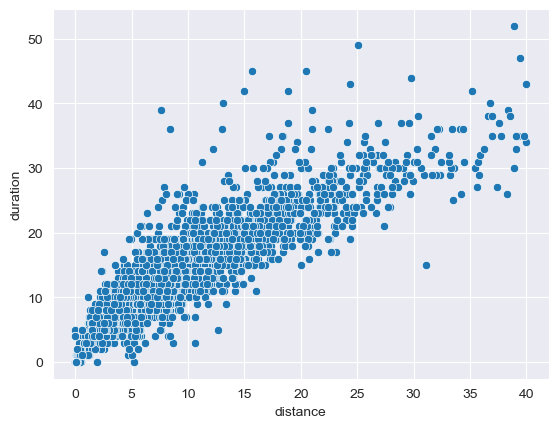

In [30]:
sns.scatterplot(data_peak_s, x='distance', y='duration')

100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  6.38it/s]


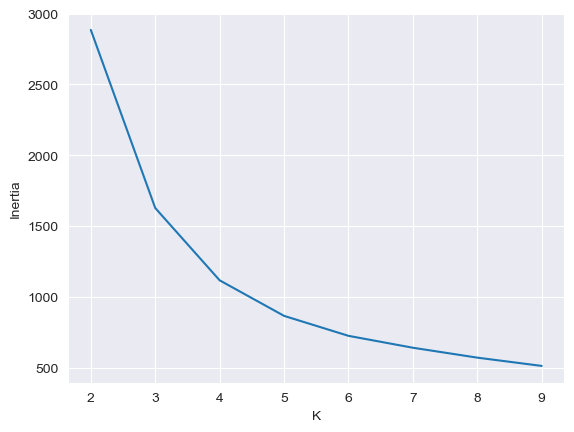

In [31]:
sse={}

for k in tqdm(range(2, 10)):
    sse[k] = get_clusters_info_elbow(peak_features, k)
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("K")
plt.ylabel('Inertia')
plt.show()

100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  6.21it/s]


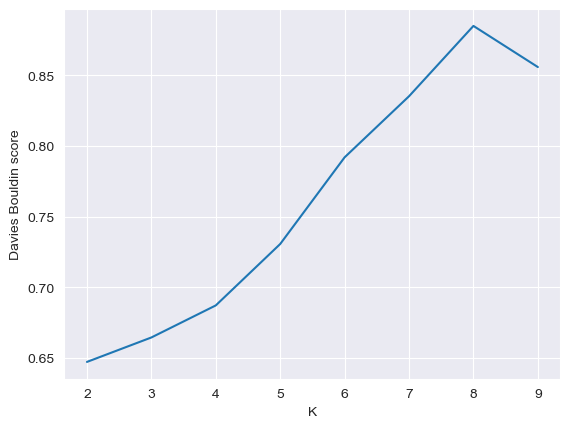

In [32]:
sse={}

for k in tqdm(range(2, 10)):
    sse[k] = get_clusters_info_db(peak_features, k)
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('K')
plt.ylabel('Davies Bouldin score')
plt.show()

In [33]:
kmeans = KMeans(n_clusters=7, max_iter=1000, random_state=42)
kmeans.fit(peak_features)

data_peak_s['cluster'] = kmeans.predict(peak_features)

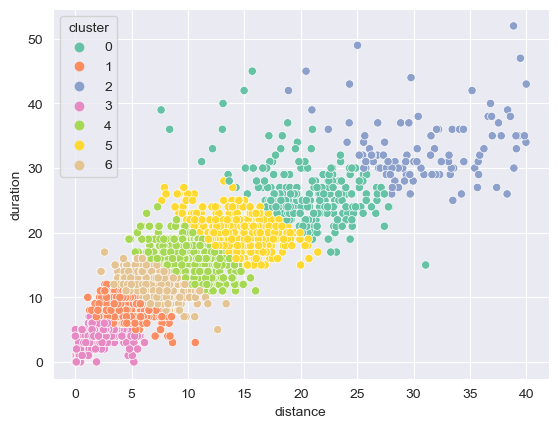

In [34]:
sns.scatterplot(data_peak_s, x='distance', y='duration', hue='cluster', palette='Set2')
plt.savefig('pics/jeddah_2_peak.png')
plt.show()

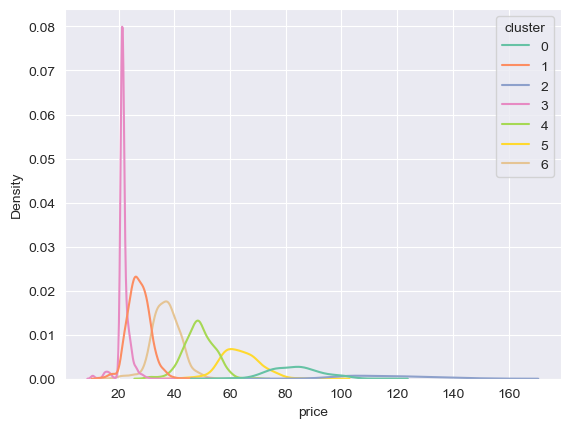

In [35]:
sns.kdeplot(data_peak_s, x='price', hue='cluster', palette='Set2')
plt.savefig('pics/jeddah_2_peak_price.png')
plt.show()

In [36]:
peak_ranges = data_peak_s[['cluster', 'price']]\
    .groupby(by='cluster')\
    .agg(['mean', q_low, q_high, 'std'])\
    .droplevel(axis=1, level=0)\
    .reset_index(drop=False)

peak_ranges['max'] = peak_ranges['q_high']/peak_ranges['mean']
peak_ranges['min'] = peak_ranges['q_low']/peak_ranges['mean']

In [37]:
peak_ranges['min'].mean()

0.7058963724918118

In [38]:
peak_ranges['max'].mean()

1.2853462319909017

In [39]:
peak_ranges

,cluster,mean,q_low,q_high,std,max,min
0,0,83.580667,58.677500,107.397500,9.086556,1.284956,0.702046
1,1,27.278368,16.866250,37.596249,3.893006,1.378244,0.618301
2,2,116.011154,71.462500,156.942500,14.748794,1.352823,0.615997
3,3,21.777919,20.237501,23.017499,2.280963,1.056919,0.929267
4,4,48.934422,35.260000,62.860000,5.462893,1.284576,0.720556
5,5,63.645910,44.600000,82.360000,7.033777,1.294034,0.700752
6,6,37.135806,24.300000,49.980000,5.110483,1.345871,0.654355


In [40]:
for peak_value in tqdm(np.sort(data_peak.peak.unique())):
    data_peak_s = data_peak[data_peak.peak == peak_value].copy()
    peak_features = data_peak_s[['distance', 'duration']].copy()

    scaler = StandardScaler()
    peak_features = scaler.fit_transform(peak_features)
    peak_features = pd.DataFrame(peak_features, columns=['distance', 'duration'])
    
    kmeans = KMeans(n_clusters=7, max_iter=1000, random_state=42)
    kmeans.fit(peak_features)

    data_peak_s['cluster'] = kmeans.predict(peak_features)
    
    peak_ranges = data_peak_s[['cluster', 'price']]\
        .groupby(by='cluster')\
        .agg(['mean', q_low, q_high])\
        .droplevel(axis=1, level=0)\
        .reset_index(drop=False)
    
    # peak_ranges = peak_ranges[(peak_ranges['mean'] > peak_ranges['mean'].min()) & (peak_ranges['mean'] < peak_ranges['mean'].max())]

    peak_ranges['max'] = peak_ranges['q_high']/peak_ranges['mean']
    peak_ranges['min'] = peak_ranges['q_low']/peak_ranges['mean']
    ranges_list.append({'peak': peak_value, 'min': peak_ranges['min'].mean(), 'max': peak_ranges['max'].mean()})

100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.49it/s]


In [41]:
ranges_data = pd.DataFrame(ranges_list)

In [42]:
ranges_data

,peak,min,max
0,1.0,0.695943,1.307857
1,1.1,0.711809,1.292141
2,1.2,0.709079,1.290409
3,1.3,0.699581,1.301690
4,1.4,0.708966,1.291835
5,1.5,0.708998,1.289985
6,1.6,0.707103,1.290144
7,1.7,0.709458,1.290046
8,1.8,0.709452,1.287044
9,1.9,0.713908,1.277881


In [43]:
ranges_melted = ranges_data.set_index('peak', drop=True).unstack().reset_index(drop=False)

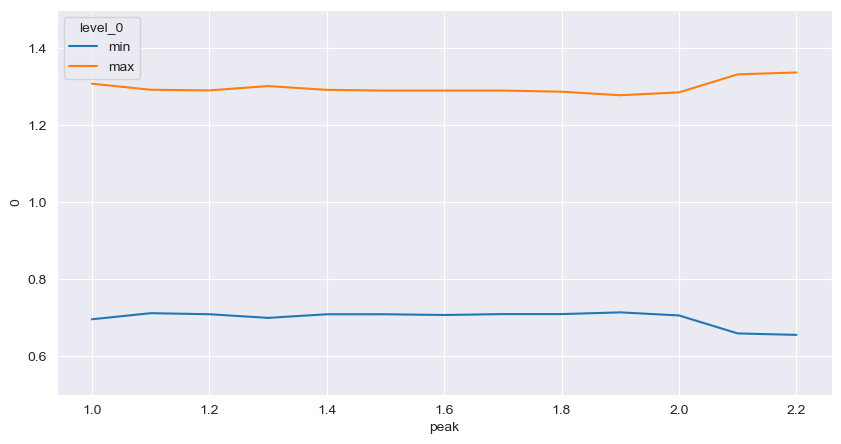

In [44]:
plt.figure(figsize=(10, 5))
sns.lineplot(ranges_melted, x='peak', y=0, hue='level_0')
plt.ylim(0.5, 1.5)
plt.savefig('pics/jeddah_gaps.png')
plt.show()

### Function

In [45]:
from scipy.interpolate import interp1d

In [46]:
def calmer_max(peak_factors: np.array) -> (float, float):
    x = np.array([1.0, 1.1, 1.3, 1.5, 1.7, 2.0, 3.0, 4.0]) # [1.0, 1.1, 1.5, 3.0, 4.0]
    y = np.array([1.30, 1.27, 1.18, 1.11, 1.07, 1.05, 1.02, 1.0]) # [1.25, 1.248, 1.2, 1.08, 1.05]
    inperp_f = interp1d(x, y, kind='cubic')
    return inperp_f(peak_factors)


def calmer_min(peak_factors: np.array) -> (float, float):
    x = np.array([1.0, 1.1, 1.3, 1.5, 1.7, 2.0, 3.0, 4.0]) # [1.0, 1.1, 1.5, 3.0, 4.0]
    y = np.array([0.75, 0.77, 0.81, 0.83, 0.85, 0.875, 0.9, 1.0]) # [0.75, 0.752, 0.8, 0.90, 0.92]
    inperp_f = interp1d(x, y, kind='cubic')
    return inperp_f(peak_factors)

In [47]:
calmed = pd.DataFrame(np.sort(data.peak.unique()), columns=['peak'])
dummy = pd.DataFrame([4.0], columns=['peak'])
calmed = pd.concat([calmed, dummy])
calmed['max'] = calmer_max(calmed['peak'].values)
calmed['min'] = calmer_min(calmed['peak'].values)

calmed_melted = calmed.set_index('peak', drop=True)\
    .unstack()\
    .reset_index(drop=False)\
    .rename(columns={'level_0': 'type', 0: 'relative bound'})

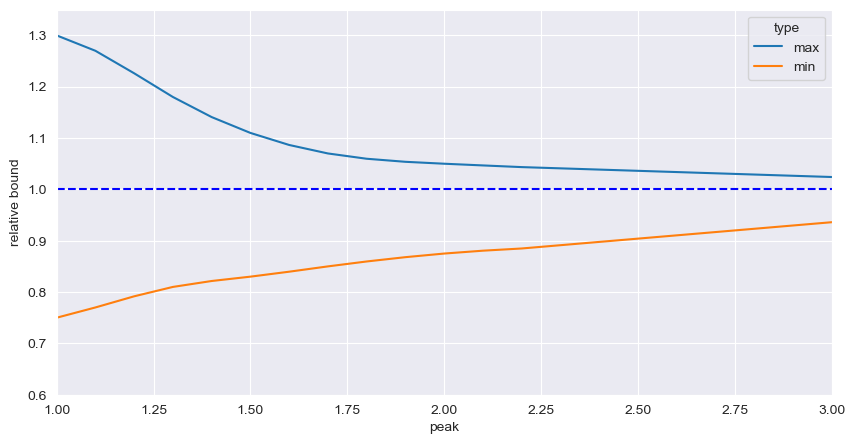

In [48]:
plt.figure(figsize=(10, 5))
a = sns.lineplot(calmed_melted, x='peak', y='relative bound', hue='type')
a.set(ylim=(0.6, 1.35), xlim=(1.0, 3.0))
a.axhline(y=1.0, color='blue', linestyle='--')
plt.savefig('pics/function.png')

In [49]:
def price_suggester(sp: float, peak_factor: float) -> np.ndarray:
    upper = float(calmer_max(peak_factor))
    lower = float(calmer_min(peak_factor))
    
    inter_upper = 1.0 + ((upper - 1.0)/2)
    inter_lower = 1.0 - ((1.0 - lower)/2)
    
    return np.array([
        round(lower*sp, 2),
        round(inter_lower*sp, 2),
        round(sp, 2),
        round(inter_upper*sp, 2),
        round(upper*sp, 2),
    ])

In [50]:
price_suggester(150, 2.0)

array([131.25, 140.62, 150.  , 153.75, 157.5 ])

In [51]:
import typing
from scipy.interpolate import interp1d


class PriceSuggester(object):
    @staticmethod
    def _calmer_max() -> typing.Callable:
        x = np.array([1.0, 1.1, 1.3, 1.5, 1.7, 2.0, 3.0, 4.0])
        y = np.array([1.30, 1.27, 1.18, 1.11, 1.07, 1.05, 1.02, 1.0])
        return interp1d(x, y, kind='cubic')

    @staticmethod
    def _calmer_min() -> typing.Callable:
        x = np.array([1.0, 1.1, 1.3, 1.5, 1.7, 2.0, 3.0, 4.0])
        y = np.array([0.75, 0.77, 0.81, 0.83, 0.85, 0.875, 0.9, 1.0])
        return interp1d(x, y, kind='cubic')
    
    def get_bounds(self, peak_factor: float) -> (float, float):
        upper = float(self._calmer_max()(peak_factor))
        lower = float(self._calmer_min()(peak_factor))
        return (lower, upper)
    
    def suggest(self, sp: float, peak_factor: float) -> np.ndarray:
        lower, upper = self.get_bounds(peak_factor)

        inter_upper = 1.0 + ((upper - 1.0)/2)
        inter_lower = 1.0 - ((1.0 - lower)/2)

        return np.array([
            round(lower*sp, 2),
            round(inter_lower*sp, 2),
            round(sp, 2),
            round(inter_upper*sp, 2),
            round(upper*sp, 2),
        ])

### Sim

In [52]:
clusters = ranges[['mean']]\
    .sort_values(by='mean')\
    .reset_index(drop=True)\
    .reset_index(drop=False)\
    .rename(columns={'index': 'cluster'})

In [53]:
clusters['mean'] = round(clusters['mean'], 2)

In [54]:
for peak_value in tqdm(np.sort(data.peak.unique())):
    ps = PriceSuggester()
    bounds = tuple([round(x, 4) for x in ps.get_bounds(peak_value)])
    clusters[f'peak: {peak_value} | bounds: {bounds}'] = [str(ps.suggest(peak_value*x, peak_value).tolist()) for x in clusters['mean'].values]

100%|██████████████████████████████████████████| 13/13 [00:00<00:00, 355.45it/s]


In [55]:
clusters

,cluster,mean,"peak: 1.0 | bounds: (0.75, 1.3)","peak: 1.1 | bounds: (0.77, 1.27)","peak: 1.2 | bounds: (0.7917, 1.2262)","peak: 1.3 | bounds: (0.81, 1.18)","peak: 1.4 | bounds: (0.8215, 1.1409)","peak: 1.5 | bounds: (0.83, 1.11)","peak: 1.6 | bounds: (0.8397, 1.0865)","peak: 1.7 | bounds: (0.85, 1.07)","peak: 1.8 | bounds: (0.8596, 1.0597)","peak: 1.9 | bounds: (0.868, 1.0537)","peak: 2.0 | bounds: (0.875, 1.05)","peak: 2.1 | bounds: (0.8806, 1.0467)","peak: 2.2 | bounds: (0.8849, 1.0434)"
0,0,11.37,"[8.53, 9.95, 11.37, 13.08, 14.78]","[9.63, 11.07, 12.51, 14.2, 15.88]","[10.8, 12.22, 13.64, 15.19, 16.73]","[11.97, 13.38, 14.78, 16.11, 17.44]","[13.08, 14.5, 15.92, 17.04, 18.16]","[14.16, 15.61, 17.06, 17.99, 18.93]","[15.28, 16.73, 18.19, 18.98, 19.77]","[16.43, 17.88, 19.33, 20.01, 20.68]","[17.59, 19.03, 20.47, 21.08, 21.69]","[18.75, 20.18, 21.6, 22.18, 22.76]","[19.9, 21.32, 22.74, 23.31, 23.88]","[21.03, 22.45, 23.88, 24.43, 24.99]","[22.13, 23.57, 25.01, 25.56, 26.1]"
1,1,15.49,"[11.62, 13.55, 15.49, 17.81, 20.14]","[13.12, 15.08, 17.04, 19.34, 21.64]","[14.72, 16.65, 18.59, 20.69, 22.79]","[16.31, 18.22, 20.14, 21.95, 23.76]","[17.82, 19.75, 21.69, 23.21, 24.74]","[19.29, 21.26, 23.24, 24.51, 25.79]","[20.81, 22.8, 24.78, 25.86, 26.93]","[22.38, 24.36, 26.33, 27.25, 28.18]","[23.97, 25.92, 27.88, 28.71, 29.55]","[25.55, 27.49, 29.43, 30.22, 31.01]","[27.11, 29.04, 30.98, 31.75, 32.53]","[28.64, 30.59, 32.53, 33.29, 34.05]","[30.15, 32.12, 34.08, 34.82, 35.56]"
2,2,21.32,"[15.99, 18.66, 21.32, 24.52, 27.72]","[18.06, 20.76, 23.45, 26.62, 29.78]","[20.25, 22.92, 25.58, 28.48, 31.37]","[22.45, 25.08, 27.72, 30.21, 32.7]","[24.52, 27.18, 29.85, 31.95, 34.05]","[26.54, 29.26, 31.98, 33.74, 35.5]","[28.64, 31.38, 34.11, 35.59, 37.06]","[30.81, 33.53, 36.24, 37.51, 38.78]","[32.99, 35.68, 38.38, 39.52, 40.67]","[35.16, 37.83, 40.51, 41.6, 42.68]","[37.31, 39.98, 42.64, 43.71, 44.77]","[39.43, 42.1, 44.77, 45.82, 46.86]","[41.5, 44.2, 46.9, 47.92, 48.94]"
3,3,27.83,"[20.87, 24.35, 27.83, 32.0, 36.18]","[23.57, 27.09, 30.61, 34.75, 38.88]","[26.44, 29.92, 33.4, 37.17, 40.95]","[29.3, 32.74, 36.18, 39.44, 42.69]","[32.01, 35.49, 38.96, 41.71, 44.45]","[34.65, 38.2, 41.74, 44.04, 46.34]","[37.39, 40.96, 44.53, 46.45, 48.38]","[40.21, 43.76, 47.31, 48.97, 50.62]","[43.06, 46.58, 50.09, 51.59, 53.08]","[45.9, 49.39, 52.88, 54.3, 55.72]","[48.7, 52.18, 55.66, 57.05, 58.44]","[51.46, 54.95, 58.44, 59.81, 61.17]","[54.18, 57.7, 61.23, 62.55, 63.88]"
4,4,35.94,"[26.96, 31.45, 35.94, 41.33, 46.72]","[30.44, 34.99, 39.53, 44.87, 50.21]","[34.14, 38.64, 43.13, 48.01, 52.88]","[37.84, 42.28, 46.72, 50.93, 55.13]","[41.34, 45.83, 50.32, 53.86, 57.4]","[44.75, 49.33, 53.91, 56.88, 59.84]","[48.28, 52.89, 57.5, 59.99, 62.48]","[51.93, 56.52, 61.1, 63.24, 65.37]","[55.61, 60.15, 64.69, 66.62, 68.55]","[59.27, 63.78, 68.29, 70.12, 71.96]","[62.89, 67.39, 71.88, 73.68, 75.47]","[66.46, 70.97, 75.47, 77.24, 79.0]","[69.97, 74.52, 79.07, 80.78, 82.5]"
5,5,47.22,"[35.42, 41.32, 47.22, 54.3, 61.39]","[40.0, 45.97, 51.94, 58.95, 65.97]","[44.86, 50.76, 56.66, 63.07, 69.48]","[49.72, 55.55, 61.39, 66.91, 72.44]","[54.31, 60.21, 66.11, 70.76, 75.42]","[58.79, 64.81, 70.83, 74.73, 78.62]","[63.44, 69.49, 75.55, 78.82, 82.09]","[68.23, 74.25, 80.27, 83.08, 85.89]","[73.06, 79.03, 85.0, 87.53, 90.07]","[77.87, 83.79, 89.72, 92.13, 94.54]","[82.64, 88.54, 94.44, 96.8, 99.16]","[87.32, 93.24, 99.16, 101.48, 103.79]","[91.92, 97.9, 103.88, 106.14, 108.39]"
6,6,62.07,"[46.55, 54.31, 62.07, 71.38, 80.69]","[52.57, 60.43, 68.28, 77.49, 86.71]","[58.97, 66.73, 74.48, 82.91, 91.33]","[65.36, 73.03, 80.69, 87.95, 95.22]","[71.39, 79.14, 86.9, 93.02, 99.14]","[77.28, 85.19, 93.1, 98.23, 103.35]","[83.39, 91.35, 99.31, 103.61, 107.91]","[89.69, 97.61, 105.52, 109.21, 112.91]","[96.04, 103.88, 111.73, 115.06, 118.39]","[102.36, 110.15, 117.93, 121.1, 124.27]","[108.62, 116.38, 124.14, 127.24, 130.35]","[114.78, 122.56, 130.35, 133.39, 136.43]","[120.83, 128.69, 136.

In [56]:
# clusters.to_csv('jeddah_suggestions.csv', index=False, sep=';')